# Method 8 - Best Ideas Low Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[best_ideas['focus_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

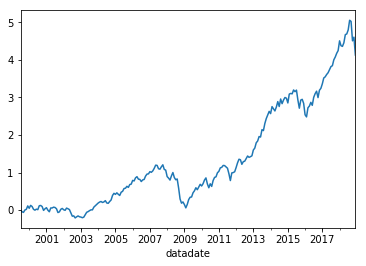

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.110956
2000-12-31   -0.068639
2001-12-31    0.008809
2002-12-31   -0.212397
2003-12-31    0.399525
2004-12-31    0.256924
2005-12-31    0.169176
2006-12-31    0.161458
2007-12-31    0.051025
2008-12-31   -0.410390
2009-12-31    0.385876
2010-12-31    0.181427
2011-12-31    0.013970
2012-12-31    0.210262
2013-12-31    0.483580
2014-12-31    0.096678
2015-12-31   -0.034537
2016-12-31    0.104218
2017-12-31    0.236822
2018-12-31   -0.022750
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     633.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.47e-122
Time:                        06:30:37   Log-Likelihood:                 682.68
No. Observations:                 234   AIC:                            -1355.
Df Residuals:                     229   BIC:                            -1338.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.344      0.001       0.001       0.005
mktrf          0.9558      0.025     38.746      0.000       0.907       1.004
me             0.2581      0.029      8.994      0.000       0.202       0.315
ia            -0.0396      0.044     -0.908      0.365      -0.126       0.046
roe            0.0810      0.037      2.171      0.031       0.007       0.155
==============================================================================
Omnibus:                       17.742   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.859
Skew:                          -0.243   Prob(JB):                     6.68e-11
Kurtosis:                       5.138   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     632.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.82e-122
Time:                        06:30:37   Log-Likelihood:                 682.68
No. Observations:                 234   AIC:                            -1355.
Df Residuals:                     229   BIC:                            -1338.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.190      0.001       0.001       0.005
mktrf          0.9558      0.026     36.576      0.000       0.905       1.007
me             0.2581      0.032      8.146      0.000       0.196       0.320
ia            -0.0396      0.073     -0.542      0.588      -0.183       0.104
roe            0.0810      0.041      1.985      0.047       0.001       0.161
==============================================================================
Omnibus:                       17.742   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.859
Skew:                          -0.243   Prob(JB):                     6.68e-11
Kurtosis:                       5.138   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     792.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.04e-133
Time:                        06:30:37   Log-Likelihood:                 682.68
No. Observations:                 234   AIC:                            -1355.
Df Residuals:                     229   BIC:                            -1338.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.142      0.002       0.001       0.005
mktrf          0.9558      0.022     42.706      0.000       0.912       1.000
me             0.2581      0.029      8.943      0.000       0.202       0.315
ia            -0.0396      0.082     -0.482      0.630      -0.201       0.121
roe            0.0810      0.036      2.221      0.026       0.010       0.153
==============================================================================
Omnibus:                       17.742   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.859
Skew:                          -0.243   Prob(JB):                     6.68e-11
Kurtosis:                       5.138   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     459.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.11e-117
Time:                        06:30:37   Log-Likelihood:                 672.61
No. Observations:                 234   AIC:                            -1333.
Df Residuals:                     228   BIC:                            -1312.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.121      0.002       0.001       0.005
mktrf          0.9506      0.026     36.762      0.000       0.900       1.002
smb            0.2833      0.034      8.303      0.000       0.216       0.351
hml           -0.0054      0.040     -0.135      0.893      -0.085       0.074
rmw            0.0726      0.045      1.597      0.112      -0.017       0.162
cma           -0.0271      0.058     -0.469      0.640      -0.141       0.087
==============================================================================
Omnibus:                       19.715   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.184
Skew:                          -0.311   Prob(JB):                     7.68e-12
Kurtosis:                       5.205   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     566.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.34e-126
Time:                        06:30:37   Log-Likelihood:                 672.61
No. Observations:                 234   AIC:                            -1333.
Df Residuals:                     228   BIC:                            -1312.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.770      0.006       0.001       0.005
mktrf          0.9506      0.037     26.022      0.000       0.879       1.022
smb            0.2833      0.038      7.370      0.000       0.208       0.359
hml           -0.0054      0.075     -0.072      0.942      -0.153       0.142
rmw            0.0726      0.058      1.249      0.212      -0.041       0.187
cma           -0.0271      0.113     -0.240      0.810      -0.248       0.194
==============================================================================
Omnibus:                       19.715   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.184
Skew:                          -0.311   Prob(JB):                     7.68e-12
Kurtosis:                       5.205   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     703.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.12e-136
Time:                        06:30:37   Log-Likelihood:                 672.61
No. Observations:                 234   AIC:                            -1333.
Df Residuals:                     228   BIC:                            -1312.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.566      0.010       0.001       0.005
mktrf          0.9506      0.036     26.486      0.000       0.880       1.021
smb            0.2833      0.035      8.045      0.000       0.214       0.352
hml           -0.0054      0.079     -0.068      0.946      -0.161       0.150
rmw            0.0726      0.054      1.345      0.178      -0.033       0.178
cma           -0.0271      0.119     -0.227      0.820      -0.261       0.207
==============================================================================
Omnibus:                       19.715   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.184
Skew:                          -0.311   Prob(JB):                     7.68e-12
Kurtosis:                       5.205   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     570.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.46e-118
Time:                        06:30:38   Log-Likelihood:                 671.47
No. Observations:                 234   AIC:                            -1333.
Df Residuals:                     229   BIC:                            -1316.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.244      0.001       0.001       0.005
mktrf          0.9704      0.024     40.730      0.000       0.923       1.017
smb            0.2064      0.030      6.940      0.000       0.148       0.265
hml            0.0689      0.030      2.333      0.021       0.011       0.127
umd            0.0631      0.019      3.257      0.001       0.025       0.101
==============================================================================
Omnibus:                       22.774   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.764
Skew:                          -0.379   Prob(JB):                     6.39e-14
Kurtosis:                       5.379   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     720.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.13e-128
Time:                        06:30:38   Log-Likelihood:                 671.47
No. Observations:                 234   AIC:                            -1333.
Df Residuals:                     229   BIC:                            -1316.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.782      0.005       0.001       0.005
mktrf          0.9704      0.030     31.913      0.000       0.911       1.030
smb            0.2064      0.031      6.644      0.000       0.146       0.267
hml            0.0689      0.054      1.280      0.201      -0.037       0.174
umd            0.0631      0.026      2.457      0.014       0.013       0.113
==============================================================================
Omnibus:                       22.774   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.764
Skew:                          -0.379   Prob(JB):                     6.39e-14
Kurtosis:                       5.379   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     949.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.90e-141
Time:                        06:30:38   Log-Likelihood:                 671.47
No. Observations:                 234   AIC:                            -1333.
Df Residuals:                     229   BIC:                            -1316.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.799      0.005       0.001       0.005
mktrf          0.9704      0.030     32.851      0.000       0.913       1.028
smb            0.2064      0.028      7.276      0.000       0.151       0.262
hml            0.0689      0.059      1.168      0.243      -0.047       0.185
umd            0.0631      0.023      2.705      0.007       0.017       0.109
==============================================================================
Omnibus:                       22.774   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.764
Skew:                          -0.379   Prob(JB):                     6.39e-14
Kurtosis:                       5.379   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     257.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.32e-56
Time:                        06:30:38   Log-Likelihood:                 326.73
No. Observations:                 120   AIC:                            -643.5
Df Residuals:                     115   BIC:                            -629.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.002      1.959      0.053   -3.45e-05       0.006
mktrf          0.9794      0.042     23.402      0.000       0.897       1.062
me             0.2658      0.041      6.431      0.000       0.184       0.348
ia            -0.0183      0.065     -0.283      0.778      -0.147       0.110
roe            0.1398      0.057      2.439      0.016       0.026       0.253
==============================================================================
Omnibus:                        7.161   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.028   Jarque-Bera (JB):               10.270
Skew:                          -0.258   Prob(JB):                      0.00589
Kurtosis:                       4.337   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     363.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.11e-64
Time:                        06:30:38   Log-Likelihood:                 326.73
No. Observations:                 120   AIC:                            -643.5
Df Residuals:                     115   BIC:                            -629.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.002      2.018      0.044    8.78e-05       0.006
mktrf          0.9794      0.048     20.580      0.000       0.886       1.073
me             0.2658      0.037      7.199      0.000       0.193       0.338
ia            -0.0183      0.085     -0.215      0.829      -0.185       0.148
roe            0.1398      0.062      2.251      0.024       0.018       0.261
==============================================================================
Omnibus:                        7.161   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.028   Jarque-Bera (JB):               10.270
Skew:                          -0.258   Prob(JB):                      0.00589
Kurtosis:                       4.337   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     530.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.18e-73
Time:                        06:30:38   Log-Likelihood:                 326.73
No. Observations:                 120   AIC:                            -643.5
Df Residuals:                     115   BIC:                            -629.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.052      0.040       0.000       0.006
mktrf          0.9794      0.039     25.020      0.000       0.903       1.056
me             0.2658      0.032      8.365      0.000       0.204       0.328
ia            -0.0183      0.094     -0.195      0.845      -0.202       0.166
roe            0.1398      0.051      2.734      0.006       0.040       0.240
==============================================================================
Omnibus:                        7.161   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.028   Jarque-Bera (JB):               10.270
Skew:                          -0.258   Prob(JB):                      0.00589
Kurtosis:                       4.337   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     176.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.08e-52
Time:                        06:30:38   Log-Likelihood:                 318.99
No. Observations:                 120   AIC:                            -626.0
Df Residuals:                     114   BIC:                            -609.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.002      2.025      0.045    7.53e-05       0.007
mktrf          0.9805      0.047     20.739      0.000       0.887       1.074
smb            0.3050      0.054      5.696      0.000       0.199       0.411
hml           -0.0343      0.066     -0.523      0.602      -0.164       0.096
rmw            0.1334      0.077      1.724      0.087      -0.020       0.287
cma            0.0314      0.085      0.371      0.712      -0.137       0.199
==============================================================================
Omnibus:                        7.498   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                8.325
Skew:                          -0.408   Prob(JB):                       0.0156
Kurtosis:                       3.999   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     260.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.38e-60
Time:                        06:30:38   Log-Likelihood:                 318.99
No. Observations:                 120   AIC:                            -626.0
Df Residuals:                     114   BIC:                            -609.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.002      1.874      0.061      -0.000       0.007
mktrf          0.9805      0.075     13.071      0.000       0.833       1.128
smb            0.3050      0.062      4.945      0.000       0.184       0.426
hml           -0.0343      0.124     -0.276      0.783      -0.278       0.209
rmw            0.1334      0.125      1.066      0.287      -0.112       0.379
cma            0.0314      0.144      0.218      0.827      -0.251       0.314
==============================================================================
Omnibus:                        7.498   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                8.325
Skew:                          -0.408   Prob(JB):                       0.0156
Kurtosis:                       3.999   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     307.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.18e-64
Time:                        06:30:38   Log-Likelihood:                 318.99
No. Observations:                 120   AIC:                            -626.0
Df Residuals:                     114   BIC:                            -609.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.002      1.767      0.077      -0.000       0.007
mktrf          0.9805      0.075     13.156      0.000       0.834       1.127
smb            0.3050      0.057      5.396      0.000       0.194       0.416
hml           -0.0343      0.136     -0.252      0.801      -0.301       0.232
rmw            0.1334      0.127      1.053      0.292      -0.115       0.382
cma            0.0314      0.153      0.205      0.837      -0.269       0.332
==============================================================================
Omnibus:                        7.498   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                8.325
Skew:                          -0.408   Prob(JB):                       0.0156
Kurtosis:                       3.999   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     219.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.04e-53
Time:                        06:30:38   Log-Likelihood:                 318.21
No. Observations:                 120   AIC:                            -626.4
Df Residuals:                     115   BIC:                            -612.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.002      2.609      0.010       0.001       0.007
mktrf          0.9822      0.040     24.813      0.000       0.904       1.061
smb            0.1939      0.045      4.303      0.000       0.105       0.283
hml            0.0972      0.045      2.154      0.033       0.008       0.187
umd            0.0712      0.028      2.559      0.012       0.016       0.126
==============================================================================
Omnibus:                       10.611   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               13.393
Skew:                          -0.503   Prob(JB):                      0.00124
Kurtosis:                       4.290   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     334.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.54e-62
Time:                        06:30:38   Log-Likelihood:                 318.21
No. Observations:                 120   AIC:                            -626.4
Df Residuals:                     115   BIC:                            -612.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.002      2.488      0.013       0.001       0.008
mktrf          0.9822      0.050     19.624      0.000       0.884       1.080
smb            0.1939      0.040      4.847      0.000       0.116       0.272
hml            0.0972      0.067      1.460      0.144      -0.033       0.228
umd            0.0712      0.032      2.214      0.027       0.008       0.134
==============================================================================
Omnibus:                       10.611   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               13.393
Skew:                          -0.503   Prob(JB):                      0.00124
Kurtosis:                       4.290   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     420.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.18e-67
Time:                        06:30:38   Log-Likelihood:                 318.21
No. Observations:                 120   AIC:                            -626.4
Df Residuals:                     115   BIC:                            -612.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.002      2.680      0.007       0.001       0.007
mktrf          0.9822      0.047     21.061      0.000       0.891       1.074
smb            0.1939      0.035      5.605      0.000       0.126       0.262
hml            0.0972      0.071      1.378      0.168      -0.041       0.236
umd            0.0712      0.028      2.519      0.012       0.016       0.127
==============================================================================
Omnibus:                       10.611   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               13.393
Skew:                          -0.503   Prob(JB):                      0.00124
Kurtosis:                       4.290   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     623.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.20e-74
Time:                        06:30:38   Log-Likelihood:                 387.59
No. Observations:                 114   AIC:                            -765.2
Df Residuals:                     109   BIC:                            -751.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.810      0.000       0.002       0.005
mktrf          0.9501      0.024     39.128      0.000       0.902       0.998
me             0.2250      0.037      6.001      0.000       0.151       0.299
ia            -0.1776      0.052     -3.416      0.001      -0.281      -0.075
roe           -0.1257      0.046     -2.751      0.007      -0.216      -0.035
==============================================================================
Omnibus:                        0.128   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.938   Jarque-Bera (JB):                0.044
Skew:                          -0.048   Prob(JB):                        0.978
Kurtosis:                       2.991   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1014.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.18e-85
Time:                        06:30:38   Log-Likelihood:                 387.59
No. Observations:                 114   AIC:                            -765.2
Df Residuals:                     109   BIC:                            -751.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.836      0.005       0.001       0.005
mktrf          0.9501      0.019     49.069      0.000       0.912       0.988
me             0.2250      0.021     10.911      0.000       0.185       0.265
ia            -0.1776      0.072     -2.459      0.014      -0.319      -0.036
roe           -0.1257      0.041     -3.047      0.002      -0.207      -0.045
==============================================================================
Omnibus:                        0.128   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.938   Jarque-Bera (JB):                0.044
Skew:                          -0.048   Prob(JB):                        0.978
Kurtosis:                       2.991   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1842.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.53e-99
Time:                        06:30:38   Log-Likelihood:                 387.59
No. Observations:                 114   AIC:                            -765.2
Df Residuals:                     109   BIC:                            -751.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.538      0.011       0.001       0.006
mktrf          0.9501      0.019     49.715      0.000       0.913       0.988
me             0.2250      0.019     11.961      0.000       0.188       0.262
ia            -0.1776      0.080     -2.223      0.026      -0.334      -0.021
roe           -0.1257      0.040     -3.178      0.001      -0.203      -0.048
==============================================================================
Omnibus:                        0.128   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.938   Jarque-Bera (JB):                0.044
Skew:                          -0.048   Prob(JB):                        0.978
Kurtosis:                       2.991   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     593.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.31e-77
Time:                        06:30:38   Log-Likelihood:                 397.64
No. Observations:                 114   AIC:                            -783.3
Df Residuals:                     108   BIC:                            -766.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.950      0.004       0.001       0.004
mktrf          0.9562      0.021     44.886      0.000       0.914       0.998
smb            0.2156      0.035      6.234      0.000       0.147       0.284
hml           -0.0480      0.044     -1.089      0.278      -0.135       0.039
rmw           -0.1962      0.054     -3.633      0.000      -0.303      -0.089
cma           -0.1618      0.069     -2.360      0.020      -0.298      -0.026
==============================================================================
Omnibus:                        1.046   Durbin-Watson:                   1.593
Prob(Omnibus):                  0.593   Jarque-Bera (JB):                1.127
Skew:                          -0.163   Prob(JB):                        0.569
Kurtosis:                       2.639   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     648.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.40e-79
Time:                        06:30:38   Log-Likelihood:                 397.64
No. Observations:                 114   AIC:                            -783.3
Df Residuals:                     108   BIC:                            -766.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.255      0.024       0.000       0.004
mktrf          0.9562      0.019     49.671      0.000       0.918       0.994
smb            0.2156      0.020     10.889      0.000       0.177       0.254
hml           -0.0480      0.050     -0.960      0.337      -0.146       0.050
rmw           -0.1962      0.048     -4.045      0.000      -0.291      -0.101
cma           -0.1618      0.099     -1.630      0.103      -0.356       0.033
==============================================================================
Omnibus:                        1.046   Durbin-Watson:                   1.593
Prob(Omnibus):                  0.593   Jarque-Bera (JB):                1.127
Skew:                          -0.163   Prob(JB):                        0.569
Kurtosis:                       2.639   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     641.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.41e-78
Time:                        06:30:38   Log-Likelihood:                 397.64
No. Observations:                 114   AIC:                            -783.3
Df Residuals:                     108   BIC:                            -766.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.982      0.048    2.46e-05       0.004
mktrf          0.9562      0.021     45.169      0.000       0.915       0.998
smb            0.2156      0.015     14.310      0.000       0.186       0.245
hml           -0.0480      0.049     -0.978      0.328      -0.144       0.048
rmw           -0.1962      0.059     -3.319      0.001      -0.312      -0.080
cma           -0.1618      0.091     -1.770      0.077      -0.341       0.017
==============================================================================
Omnibus:                        1.046   Durbin-Watson:                   1.593
Prob(Omnibus):                  0.593   Jarque-Bera (JB):                1.127
Skew:                          -0.163   Prob(JB):                        0.569
Kurtosis:                       2.639   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     622.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.44e-74
Time:                        06:30:38   Log-Likelihood:                 387.54
No. Observations:                 114   AIC:                            -765.1
Df Residuals:                     109   BIC:                            -751.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.878      0.063   -8.51e-05       0.003
mktrf          0.9779      0.023     42.477      0.000       0.932       1.024
smb            0.2589      0.036      7.211      0.000       0.188       0.330
hml           -0.0667      0.037     -1.804      0.074      -0.140       0.007
umd            0.0130      0.028      0.466      0.642      -0.042       0.068
==============================================================================
Omnibus:                        1.905   Durbin-Watson:                   1.453
Prob(Omnibus):                  0.386   Jarque-Bera (JB):                1.710
Skew:                          -0.300   Prob(JB):                        0.425
Kurtosis:                       2.977   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     660.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.01e-75
Time:                        06:30:38   Log-Likelihood:                 387.54
No. Observations:                 114   AIC:                            -765.1
Df Residuals:                     109   BIC:                            -751.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.456      0.146      -0.001       0.004
mktrf          0.9779      0.020     47.747      0.000       0.938       1.018
smb            0.2589      0.030      8.765      0.000       0.201       0.317
hml           -0.0667      0.037     -1.816      0.069      -0.139       0.005
umd            0.0130      0.027      0.478      0.632      -0.040       0.066
==============================================================================
Omnibus:                        1.905   Durbin-Watson:                   1.453
Prob(Omnibus):                  0.386   Jarque-Bera (JB):                1.710
Skew:                          -0.300   Prob(JB):                        0.425
Kurtosis:                       2.977   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     696.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.29e-76
Time:                        06:30:38   Log-Likelihood:                 387.54
No. Observations:                 114   AIC:                            -765.1
Df Residuals:                     109   BIC:                            -751.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.318      0.188      -0.001       0.004
mktrf          0.9779      0.022     44.269      0.000       0.935       1.021
smb            0.2589      0.028      9.393      0.000       0.205       0.313
hml           -0.0667      0.038     -1.734      0.083      -0.142       0.009
umd            0.0130      0.029      0.444      0.657      -0.044       0.070
==============================================================================
Omnibus:                        1.905   Durbin-Watson:                   1.453
Prob(Omnibus):                  0.386   Jarque-Bera (JB):                1.710
Skew:                          -0.300   Prob(JB):                        0.425
Kurtosis:                       2.977   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""